In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys

if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2

from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import numpy as np
import time
import os

## Define FCN16s model for deconvolution layers

In [2]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super(FCN16s, self).__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace = True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

## Define VGG16 for convolution layers

In [3]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super(VGGNet, self).__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):      
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        return output

In [4]:
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

## Define training parameter

In [5]:
batch_size = 4
epochs     = 80  #500
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 50
gamma      = 0.5
model_use  = "ds_final" #"domain_randomization"#"ds_final"#"style_transfer"#"virtual" # "products_20" "mini_competition"
n_class = 11   #21
# class_list = ["3m", "andes", "cocacola", "crayola", "folgers", "kellogg", "hunts", "heineken", "kleenex", "libava", "macadamia", "milo", "mm", "pocky", "stax", "swissmiss", "vanish", "viva", "raisins", "kotex"]
class_list = ["3m", "andes", "cocacola", "crayola", "folgers", "kellogg", "milo", "stax", "swissmiss", "viva"]

## Define path, directory trainning environment

In [6]:
# get data
data_dir  = os.path.join("data", model_use)
if not os.path.exists(data_dir):
    print("Data not found!")
# create dir for model
model_dir = os.path.join("models", model_use)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# create dir for score
score_dir = os.path.join("scores", model_use)
if not os.path.exists(score_dir):
    os.makedirs(score_dir)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
#use_gpu = False
if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))
    
# fcn_model.load_state_dict(torch.load("/home/arg/sis_lab_all/12-1_Pytorch-FCN/models/ds_final/virtual.pkl"))
# fcn_model.load_state_dict(torch.load("/home/arg/sis_lab_all/12-1_Pytorch-FCN/models/ds_final/style_transfer.pkl"))
# fcn_model.load_state_dict(torch.load("/home/arg/sis_lab_all/12-1_Pytorch-FCN/models/ds_final/style_transfer.pkl"))



Finish cuda loading, time elapsed 2.63901400566


## Visualize model

In [7]:
print(fcn_model)
params = list(fcn_model.parameters())

DataParallel(
  (module): FCN16s(
    (pretrained_net): VGGNet(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), str

Dataset class
-------------

``torch.utils.data.Dataset`` is an abstract class representing a
dataset.
Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$\ th sample

Let's create a dataset class for our face landmarks dataset. We will
read the csv in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.



In [8]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w      = 480, 640
val_h     = h
val_w     = w
class product_dataset(Dataset):

    def __init__(self, csv_file, phase, n_class=n_class, flip_rate=0.):
        self.data      = pd.read_csv(csv_file)
        self.means     = means
        self.n_class   = n_class
        self.flip_rate = flip_rate
        if phase == 'train':
            self.flip_rate = 0.5

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name   = self.data.iloc[idx, 0]
        img        = cv2.imread(os.path.join(data_dir, img_name),cv2.IMREAD_UNCHANGED)
        label_name = self.data.iloc[idx, 1]
        label      = cv2.imread(os.path.join(data_dir, label_name), cv2.IMREAD_GRAYSCALE)
        origin_img = img

        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)

        # reduce mean
#         print(data_dir + img_name)
#         plt.figure()
#         plt.imshow(img)
#         plt.show()
        img = img[:, :, ::-1]  # switch to BGR
        
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.size()
        target = torch.zeros(self.n_class, h, w)
        
        for index, obj in enumerate(class_list):
            if obj in img_name:
#                 print index+1, obj
                target[index+1][label == 255] = 1
                label[label == 255] = index+1

        target[0][label == 0] = 1
 
        sample = {'X': img, 'Y': target, 'l': label, 'origin': origin_img}

        return sample

## Define dataloader and optimizer

In [9]:
# initial dataloader for trainning and validation
train_file = os.path.join(data_dir, "train_real_20.csv")
val_file   = os.path.join(data_dir, "val_real_present.csv")
train_data = product_dataset(csv_file = train_file, phase = 'train')
val_data   = product_dataset(csv_file = val_file, phase = 'val', flip_rate = 0)
dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True, num_workers = 0)
val_loader = DataLoader(val_data, batch_size = 5, num_workers = 0)

dataiter = iter(val_loader)

# define loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(fcn_model.parameters(), lr = lr, momentum = momentum, weight_decay = w_decay)
# decay LR by a factor of 0.5 every step_size = 50 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)  

## Train

In [10]:
def train():
    for epoch in range(epochs):
        fcn_model.train()
        scheduler.step()
#         configs    = "FCNs_{}_batch{}_epoch{}_RMSprop_lr{}"\
#             .format(model_use, batch_size, epoch, lr)
        configs    = "FCNs_{}_epoch{}".format(model_use, epoch)
        model_path = os.path.join(model_dir, configs)
        
        ts = time.time()
        for iter, batch in enumerate(dataloader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())
            else:
                inputs, labels = Variable(batch['X']), Variable(batch['Y'])

            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if iter % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch+1, iter, loss.item()))
                
#             if iter % 2000 == 0:
#                 torch.save(fcn_model.state_dict(),model_path + '_'+str(iter)+'.pkl')
        
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        torch.save(fcn_model.state_dict(),model_path + '_epoch' + str(epoch) + '.pkl')
#         if epoch % 20 == 0:
#             torch.save(fcn_model.state_dict(),model_path + '.pkl')

        val(epoch)

## Evaluation

In [11]:
def val(epoch):
    fcn_model.eval()
    TP = np.zeros(n_class-1)
    FN = np.zeros(n_class-1)
    FP = np.zeros(n_class-1)
    total_ious = []
    pixel_accs = []
    for iter, batch in enumerate(val_loader):
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
        else:
            inputs = Variable(batch['X'])

        output = fcn_model(inputs)
        output = output.data.cpu().numpy()

        N, _, h, w = output.shape
        pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

        target = batch['l'].cpu().numpy().reshape(N, h, w)
        for p, t in zip(pred, target):
            pixel_accs.append(pixel_acc(p, t))
            _TP, _FN, _FP =  analysis(p, t, h, w)
            TP += _TP[1:n_class]
            FN += _FN[1:n_class]
            FP += _FP[1:n_class]
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    np.set_printoptions(formatter=dict(float=lambda t:"%6.4f" % t))
    print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
          .format(epoch, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('epoch:'+ str(epoch) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('epoch:'+ str(epoch) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('epoch:'+ str(epoch) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('epoch:'+ str(epoch) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('epoch:'+ str(epoch) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('epoch:'+ str(epoch) + ', class fscore: ' + str(fscore) + '\n' )  
    

def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class)
    FN = np.zeros(n_class)
    FP = np.zeros(n_class)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)

    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return float(correct)/float(total)
#     return correct / total

## Prediction Result 

In [12]:
def prediction(model_name):
    
    # load pretrain models
    state_dict = torch.load(os.path.join(model_dir, model_name))
    fcn_model.load_state_dict(state_dict)
    
    batch = dataiter.next()
    if use_gpu:
        inputs = Variable(batch['X'].cuda())
    else:
        inputs = Variable(batch['X'])
    img    = batch['origin'] 
    label  = batch['l']
    
    output = fcn_model(inputs)
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    plt.figure(figsize = (10, 12))
    img = img.numpy()
    for i in range(N):
        img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
        plt.subplot(N, 3, i*3 + 1)
        plt.title("origin_img")
        plt.imshow(img[i])
        #print(np.unique(_img[i]))

        plt.subplot(N, 3, i*3 + 2)
        plt.title("label_img")
        plt.imshow(label[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

        plt.subplot(N, 3, i*3 + 3)
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

    plt.show()

In [13]:
# train()

In [14]:
# train()

real_806


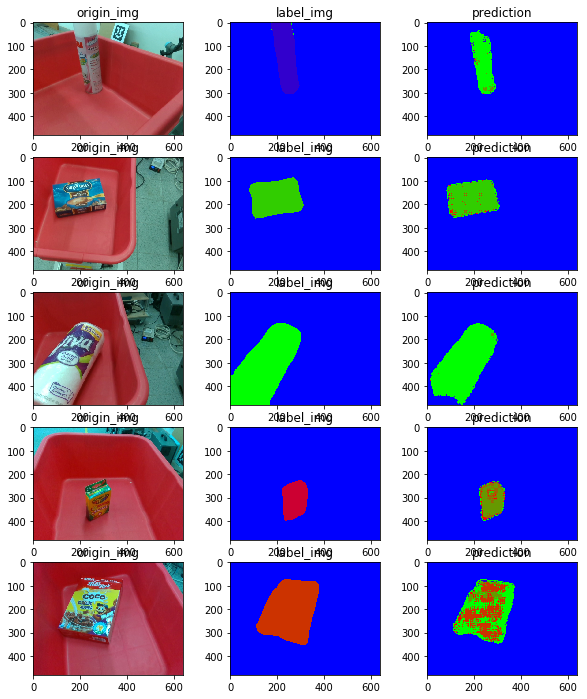

virtual with 806 real image fine-tune


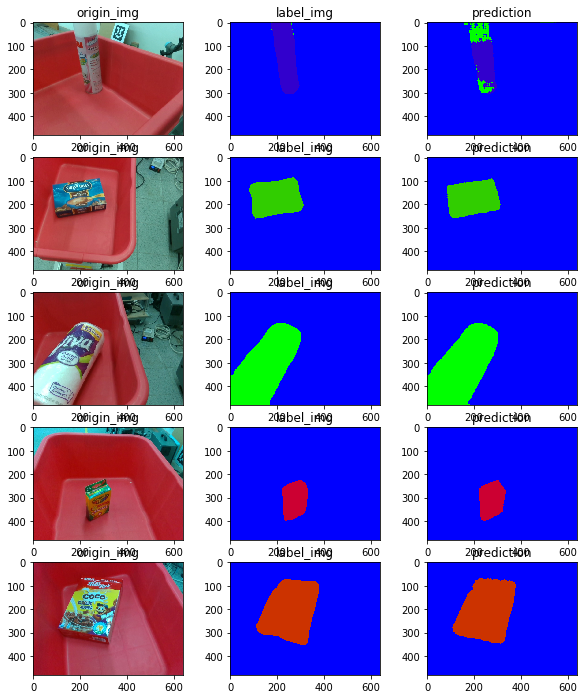

style with 806 real image fine-tune


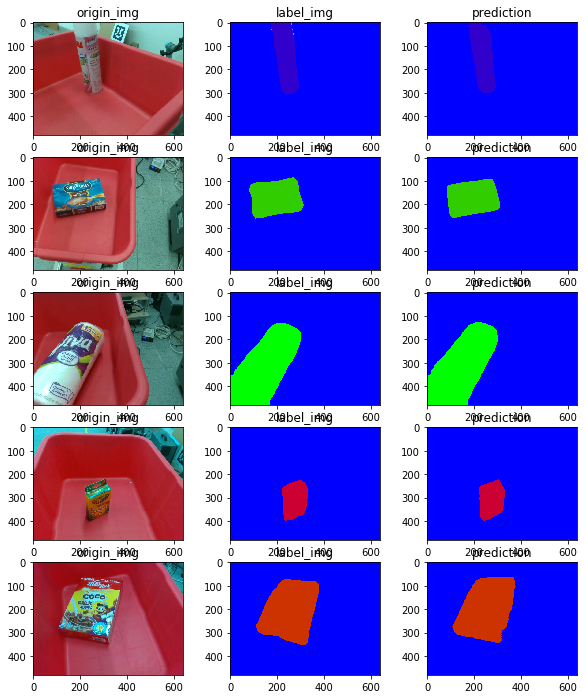

real_403


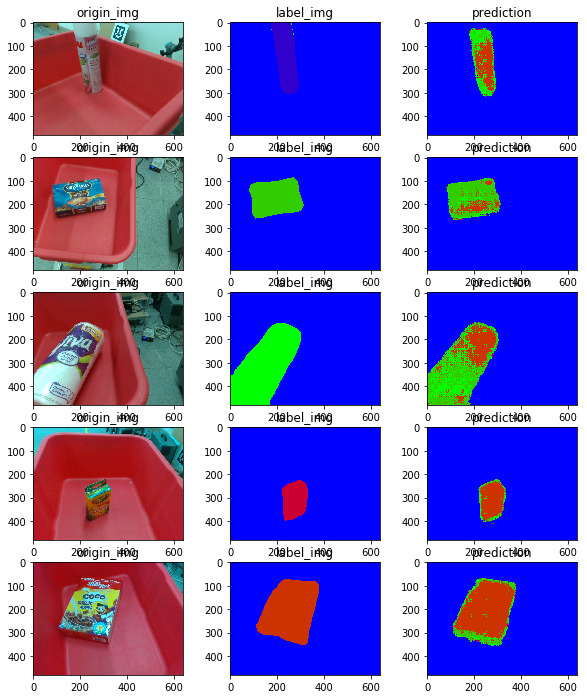

virtual with 403 real image fine-tune


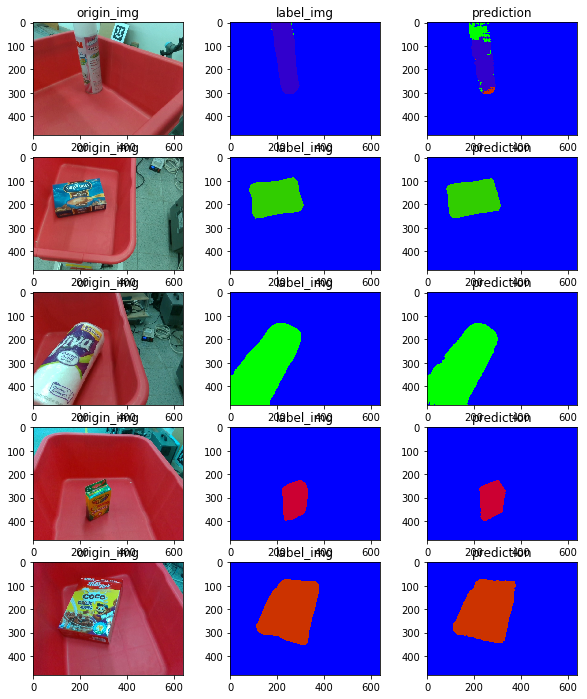

style with 403 real image fine-tune


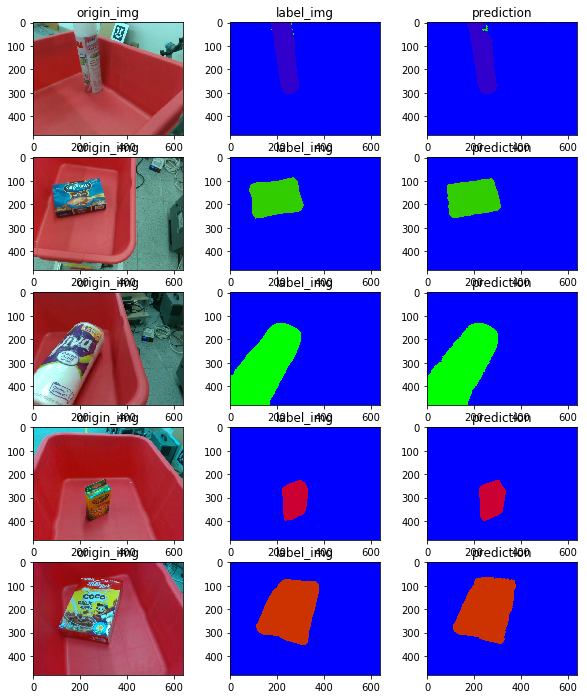

real_268


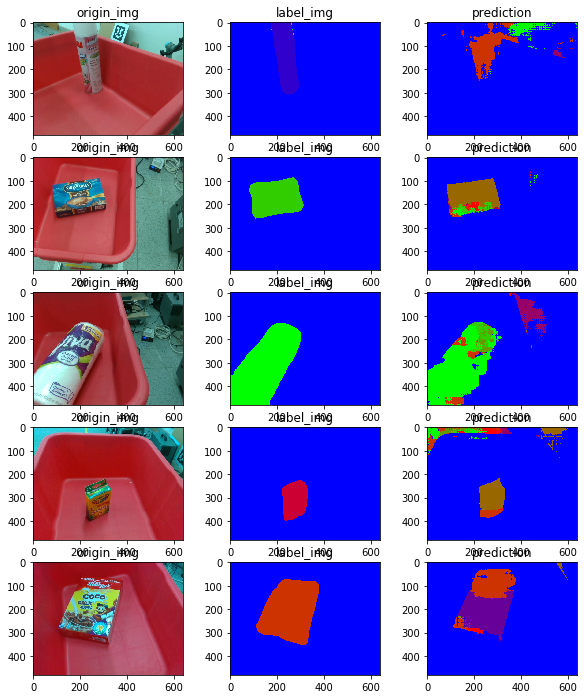

virtual with 268 real image fine-tune


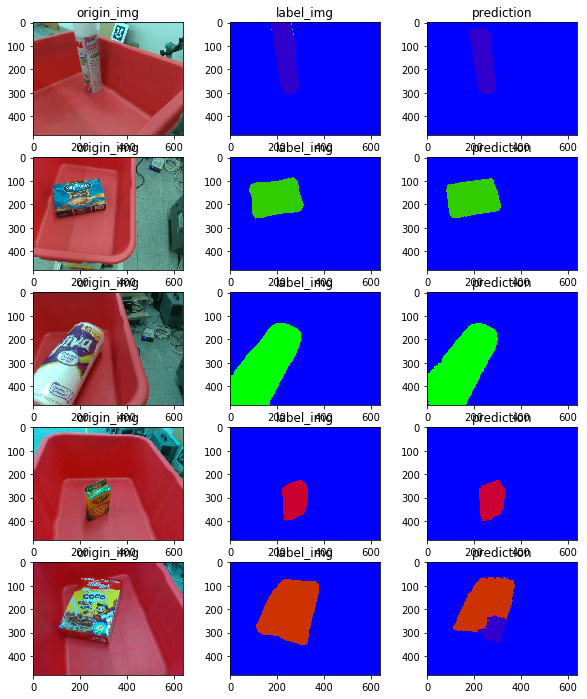

style with 268 real image fine-tune


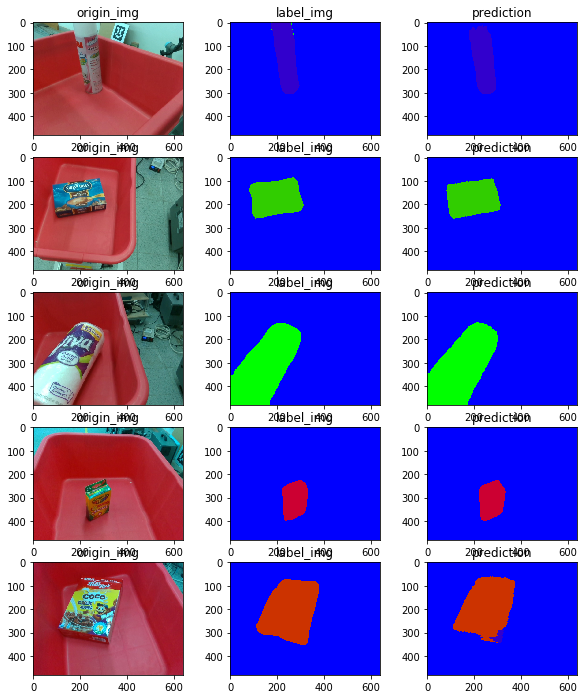

real_201


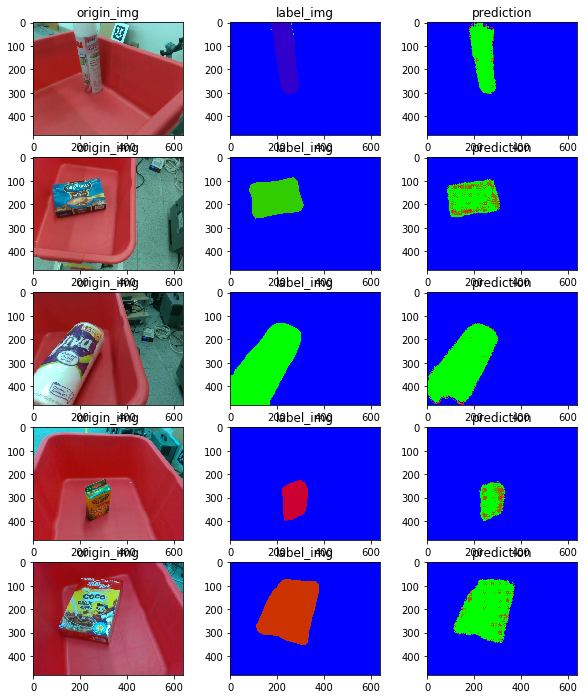

virtual with 201 real image fine-tune


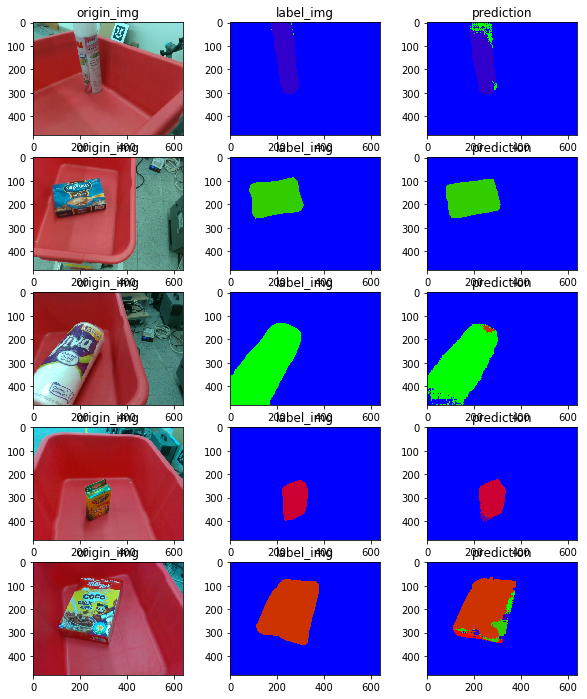

style with 201 real image fine-tune


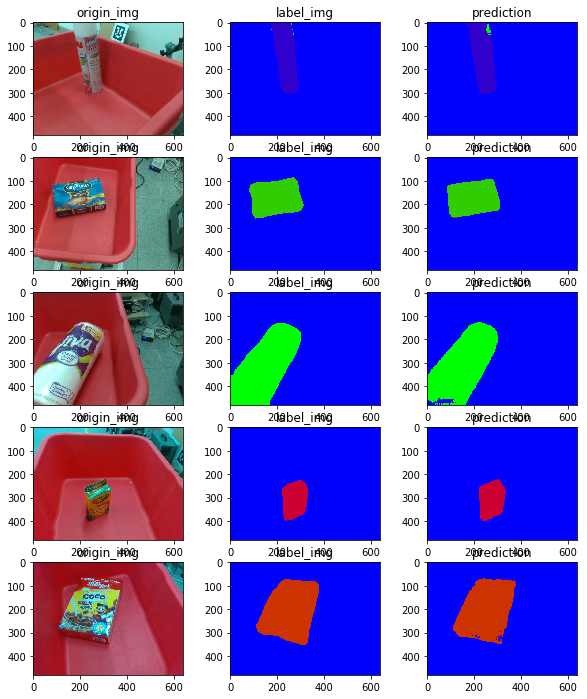

In [15]:
# print("real_batch4_epoch9")
# # prediction("real_batch4_epoch9.pkl")
# print("virtual_batch4_epoch3")
# prediction("virtual_batch4_epoch3.pkl")
# print("style_transfer_batch4_epoch8")
# prediction("style_transfer_batch4_epoch8.pkl")

print("real_806")
prediction("real_806.pkl")
print("virtual with 806 real image fine-tune")
prediction("virtual_real_806.pkl")
print("style with 806 real image fine-tune")
prediction("style_real_806.pkl")
print("=================================================================")
print("real_403")
prediction("real_403.pkl")
print("virtual with 403 real image fine-tune")
prediction("virtual_real_403.pkl")
print("style with 403 real image fine-tune")
prediction("style_real_403.pkl")
print("=================================================================")
print("real_268")
prediction("real_268.pkl")
print("virtual with 268 real image fine-tune")
prediction("virtual_real_268.pkl")
print("style with 268 real image fine-tune")
prediction("style_real_268.pkl")
# print("style with 268 real image fine-tune")
# prediction("style_real_268_f.pkl")

print("=================================================================")
print("real_201")
prediction("real_201.pkl")
print("virtual with 201 real image fine-tune")
prediction("virtual_real_201.pkl")
# print("virtual with 201 real image fine-tune")
# prediction("virtual_real_201_f.pkl")
print("style with 201 real image fine-tune")
prediction("style_real_201.pkl")
# print("style with 201 real image fine-tune")
# prediction("style_real_201_f.pkl")


In [16]:
def val_prediction(model_name, score_dir_name):
    state_dict = torch.load(os.path.join(model_dir, model_name))
    fcn_model.load_state_dict(state_dict)
    
    fcn_model.eval()
    TP = np.zeros(n_class-1)
    FN = np.zeros(n_class-1)
    FP = np.zeros(n_class-1)
    total_ious = []
    pixel_accs = []
    for iter, batch in enumerate(val_loader):
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
        else:
            inputs = Variable(batch['X'])

        output = fcn_model(inputs)
        output = output.data.cpu().numpy()

        N, _, h, w = output.shape
        pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

        target = batch['l'].cpu().numpy().reshape(N, h, w)
        
        for p, t in zip(pred, target):
            pixel_accs.append(pixel_acc(p, t))
            _TP, _FN, _FP =  analysis(p, t, h, w)
            TP += _TP[1:n_class]
            FN += _FN[1:n_class]
            FP += _FP[1:n_class]

    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    np.set_printoptions(formatter=dict(float=lambda t:"%6.4f" % t))
    print("model: {}\npix_acc: {}\nmeanIoU: {}\nIoUs:      {}\nrecall:    {}\nprecision: {}\nfscore:    {}".format(model_name,pixel_accs, np.nanmean(ious),ious, recall, precision, fscore))
    print ('             3m     andes   coca  crayo  folger kellog  milo   stax  swiss  viva')
    score_dir_name = score_dir + '/' + score_dir_name
    if not os.path.exists(score_dir_name):
        os.makedirs(score_dir_name)
    
    f1 = open(score_dir_name + "/cls_acc_log.txt","a+")
    f1.write('model: {}, pix_acc: {} \n'.format(model_name, pixel_accs))
    f2 = open(score_dir_name + "/cls_iou_log.txt","a+")
    f2.write('model: {}, class ious: {} \n'.format(model_name, ious))
    f3 = open(score_dir_name + "/mean_iou_log.txt","a+")
    f3.write('model: {}, mean IoU: {} \n'.format(model_name, np.nanmean(ious))) 
    f4 = open(score_dir_name + "/recall_log.txt","a+")
    f4.write('model: {}, class recall: {} \n'.format(model_name, recall))
    f5 = open(score_dir_name + "/precision_log.txt","a+")
    f5.write('model: {}, class precision: {} \n'.format(model_name, precision))    
    f6 = open(score_dir_name + "/fscore_log.txt","a+")
    f6.write('model: {}, class fscore: {} \n'.format(model_name, fscore))  
    

In [17]:
# print("real_806")
# val_prediction("real_806.pkl", "real_806")
# print("\n\nvirtual with 806 real image fine-tune")
# val_prediction("virtual_real_806.pkl", "virtual_real_806")
# print("\n\nstyle with 806 real image fine-tune")
# val_prediction("style_real_806.pkl", "style_real_806")

# print("real_403")
# val_prediction("real_403.pkl", "real_403")
# print("\n\nvirtual with 403 real image fine-tune")
# val_prediction("virtual_real_403.pkl", "virtual_real_403")
# print("\n\nstyle with 403 real image fine-tune")
# val_prediction("style_real_403.pkl", "style_real_403")

# print("real_268")
# val_prediction("real_268.pkl", "real_268")
# print("\n\nvirtual with 268 real image fine-tune")
# val_prediction("virtual_real_268.pkl", "virtual_real_268")
# print("\n\nstyle with 268 real image fine-tune")
# val_prediction("style_real_268.pkl", "style_real_268")
# print("\n\nfail, style with 268 real image fine-tune")
# val_prediction("style_real_268_f.pkl", "style_real_268_f")

# print("real_201")
# val_prediction("real_201.pkl", "real_201")
# print("\n\nvirtual with 201 real image fine-tune")
# val_prediction("virtual_real_201.pkl", "virtual_real_201")
# print("\n\nstyle with 201 real image fine-tune")
# val_prediction("style_real_201.pkl", "style_real_201")
# print("\n\nfail, virtual with 201 real image fine-tune")
# val_prediction("virtual_real_201_f.pkl", "virtual_real_201_f")
# print("\n\nfail, style with 201 real image fine-tune")
# val_prediction("style_real_201_f.pkl", "style_real_201_f")

In [18]:
# print("real_806")
# prediction("real_806.pkl")
# print("virtual with 806 real image fine-tune")
# prediction("virtual_real_806.pkl")
# print("style with 806 real image fine-tune")
# prediction("style_real_806.pkl")
# print("=================================================================")
# print("real_403")
# prediction("real_403.pkl")
# print("virtual with 403 real image fine-tune")
# prediction("virtual_real_403.pkl")
# print("style with 403 real image fine-tune")
# prediction("style_real_403.pkl")
# print("=================================================================")
# print("real_268")
# prediction("real_268.pkl")
# print("virtual with 268 real image fine-tune")
# prediction("virtual_real_268.pkl")
# print("style with 268 real image fine-tune")
# prediction("style_real_268.pkl")
# print("style with 268 real image fine-tune")
# prediction("style_real_268_f.pkl")

# print("=================================================================")
# print("real_201")
# prediction("real_201.pkl")
# print("virtual with 201 real image fine-tune")
# prediction("virtual_real_201.pkl")
# print("virtual with 201 real image fine-tune")
# prediction("virtual_real_201_f.pkl")
# print("style with 201 real image fine-tune")
# prediction("style_real_201.pkl")
# print("style with 201 real image fine-tune")
# prediction("style_real_201_f.pkl")